In [1]:
import numpy as np
from mpi4py import MPI
from dolfinx.mesh import create_rectangle, CellType
from meshes.truss_like_mesh import truss_like_cross
from pybandgap.fem import Fem
from pybandgap.structure import SetStructure
from pybandgap.bandgap import BandGap
import numpy as np

# structure setup

In [2]:
a = 20e-3
nx = 20
ny = nx
msh = create_rectangle(MPI.COMM_WORLD, np.array([[-a/2,-a/2],[a/2,a/2]]), [nx, ny], CellType.quadrilateral)

In [3]:
def create_linear_function(a1, a2):
    """Create a linear function between two values."""
    return lambda x: (a2 - a1) * x + a1

E_funtion =  create_linear_function(70e9,
                                    411e9)

rho_funtion =  create_linear_function(2.7e3,
                                      19.3e3)

nu_funtion = create_linear_function(0.33,
                                    0.28)

fem = Fem(msh, {'E': E_funtion,
                 'rho': rho_funtion,
                 'nu': nu_funtion})

structure = SetStructure(fem,
                        'square',
                        symmetries = {
                            'angles': [0, np.pi/2, np.pi/4],
                            'directions': ["above", "below", "below"]}
                        )
    
structure.get_elements_IBZ()

[219, 238, 255, 256, 272, 273, 287, 288, 289, 302, 303, 304, 315, 316, 317, 318, 328, 329, 330, 331, 339, 340, 341, 342, 343, 350, 351, 352, 353, 354, 359, 360, 361, 362, 363, 368, 369, 370, 371, 375, 376, 377, 378, 382, 383, 384, 387, 388, 389, 392, 393, 395, 396, 398, 399]


In [4]:
structure.set_props('E', 'x', np.array([219, 238, 255, 256, 272, 273, 287, 288, 289, 302, 303, 304, 315, 316, 317, 318, 328, 329, 330, 331]), 1)
structure.set_props('rho', 'x', np.array([219, 238, 255, 256, 272, 273, 287, 288, 289, 302, 303, 304, 315, 316, 317, 318, 328, 329, 330, 331]), 1)
structure.set_props('nu', 'x', np.array([219, 238, 255, 256, 272, 273, 287, 288, 289, 302, 303, 304, 315, 316, 317, 318, 328, 329, 330, 331]), 1)
structure.apply_symmetry()

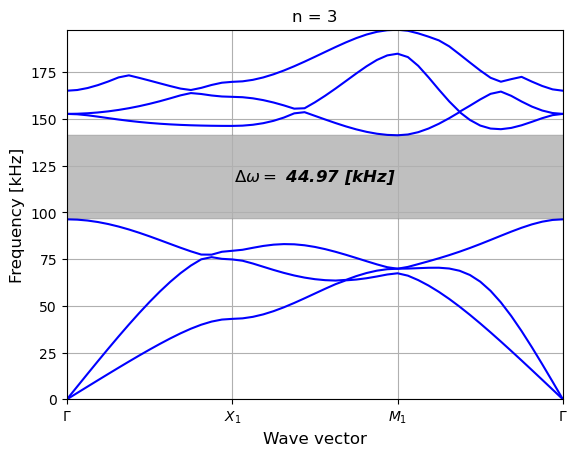

In [5]:
bg = BandGap(structure,
             NINT=60,
             n = 3)

bg.plot_bandgap()

# References
- Yi, G., Shin, Y. C., Yoon, H., Jo, S.-H., & Youn, B. D. (2019). Topology optimization for phononic band gap maximization considering a target driving frequency. JMST Advances. doi:10.1007/s42791-019-00019-y
